In [1]:
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import MSELoss
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Datasets/Lynx_Hare/data.csv', usecols=['YEAR', 'HARE', 'LYNX'])
print(df)

scaler = StandardScaler()
df[['HARE', 'LYNX']] = scaler.fit_transform(df[['HARE', 'LYNX']])

features = torch.tensor(df[['HARE', 'LYNX']].values, dtype=torch.float)
print(features)

    YEAR   HARE   LYNX
0   1845  19.58  30.09
1   1846  19.60  45.15
2   1847  19.61  49.15
3   1848  11.99  39.52
4   1849  28.04  21.23
..   ...    ...    ...
86  1931  19.52   8.31
87  1932  82.11  16.01
88  1933  89.76  24.82
89  1934  81.66  29.70
90  1935  15.76  35.40

[91 rows x 3 columns]
tensor([[-0.7139,  0.0935],
        [-0.7134,  0.8962],
        [-0.7131,  1.1094],
        [-0.9237,  0.5961],
        [-0.4801, -0.3788],
        [ 0.3481, -1.0616],
        [ 0.8070, -1.2141],
        [ 0.8206, -1.2397],
        [ 1.1907, -0.9683],
        [ 0.4388, -0.4657],
        [ 0.8089,  0.2438],
        [ 1.1791,  0.3221],
        [ 0.6387,  0.0668],
        [-0.3653, -0.3751],
        [-0.9058, -0.7807],
        [-0.6611, -1.1027],
        [-0.4162, -1.2930],
        [-1.1949, -1.2924],
        [ 2.9646, -0.7466],
        [ 2.8460,  0.5268],
        [ 1.1169,  1.7293],
        [-0.1105,  2.2618],
        [-0.8474,  2.3685],
        [-1.1922,  0.7646],
        [-1.0918, -0.6368],
 

In [3]:
edge_index = torch.tensor([[0], [1]], dtype=torch.long)  # Lynx -> Hare
x = features
data = Data(x=x, edge_index=edge_index)

In [4]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

model = GNN()

In [5]:
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()

y = features  
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

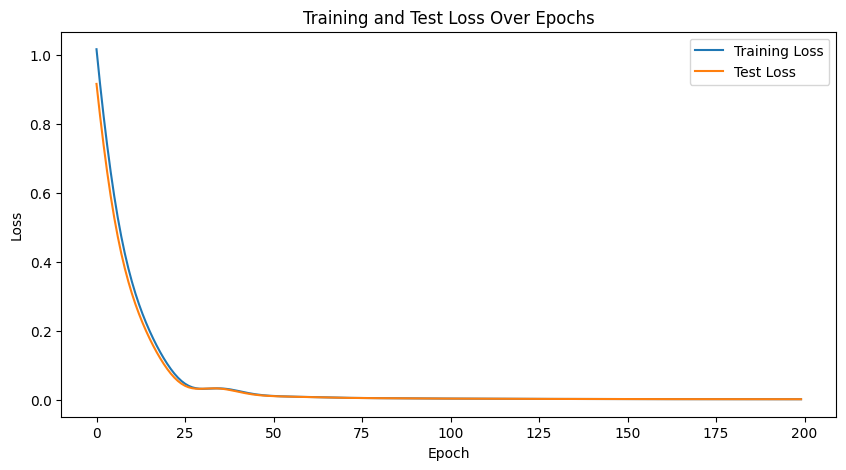

Final Test MSE: 0.0020115249790251255


In [6]:
train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    train_loss = criterion(out, data.x)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data)
        test_loss = criterion(test_pred, data.x)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    test_pred = model(data)
    mse_test = criterion(test_pred, data.x)

print(f'Final Test MSE: {mse_test.item()}')